# make rasters and do GPFA/PCA

This works with the outputs of sort_rasters_stim-bird-sess-[epoch]-machine:
    - clustered spikes with nucleus metadata (clu_df.pickle, spk_df.pickle)
    - parsed stimuli timestamps, synced to the ap_0 time basis (stim_dict_ap0.pkl, stim_pd_ap0.pkl)
    
For an epoch session:
 - Load  spikes
 - make and view some 'stim rasters'
 - Get gaussian process factors
 - Get histogram principal components
 

In [1]:
%matplotlib inline

import os
import glob
import logging
import pickle
import socket
import tempfile
import multiprocessing
import json

import numpy as np
import pandas as pd

from scipy.io import wavfile
from scipy import signal
from matplotlib import pyplot as plt

from importlib import reload
from multiprocessing import Process


logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

N_JOBS_MAX = multiprocessing.cpu_count()

logger.info('Running on {}'.format(socket.gethostname()))

2022-04-22 10:56:53,776 root         INFO     Running on pakhi


In [2]:
## pipeline and preprocess modules
from ceciestunepipe.file import bcistructure as et

from ceciestunepipe.util import sglxutil as sglu
from ceciestunepipe.util import sglxsync as sy
from ceciestunepipe.util import stimutil as su
from ceciestunepipe.util import plotutil as pu
from ceciestunepipe.util import wavutil as wu
from ceciestunepipe.util.spike import kilosort as ks
from ceciestunepipe.util.sound import spectral as sp
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import readSGLX as rsgl
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import spikeglxrecordingextractor as sglex

import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw


## format and gpfa/pca modules
import neo
import quantities as pq
from elephant.gpfa import GPFA
from sklearn.decomposition import PCA

from scipy.ndimage import gaussian_filter1d

logger.info('all modules loaded')

2022-04-22 10:56:55,494 root         INFO     all modules loaded


### Session parameters and raw files

In [3]:
reload(et)

bird = 'z_r12r13_21'
all_bird_sess = et.list_sessions(bird)
#all_bird_sess

In [4]:
reload(et)

sess_par = {'bird': bird,
           'sess': '2021-06-28',
           'probe': 'probe_0',
           'sort': 'sort_0',
            'ref_stream': 'ap_0', #what to syncrhonize everything to
           }

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sort=sess_par['sort'])

ksort_folder = exp_struct['folders']['ksort']
raw_folder = exp_struct['folders']['sglx']

In [5]:
sess_epochs = et.list_sgl_epochs(sess_par)
sess_epochs

2022-04-22 10:56:55,883 ceciestunepipe.file.bcistructure INFO     {'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/z_r12r13_21', 'raw': '/mnt/sphere/speech_bci/raw_data/z_r12r13_21/2021-06-28', 'sglx': '/mnt/sphere/speech_bci/raw_data/z_r12r13_21/2021-06-28/sglx', 'kwik': '/scratch/earneodo/z_r12r13_21/sglx/kwik/2021-06-28', 'processed': '/mnt/sphere/speech_bci/processed_data/z_r12r13_21/2021-06-28/sglx', 'derived': '/mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-06-28/sglx', 'tmp': '/scratch/earneodo/tmp', 'msort': '/scratch/earneodo/z_r12r13_21/sglx/msort/2021-06-28', 'ksort': '/scratch/earneodo/z_r12r13_21/sglx/ksort/2021-06-28/sort_0', 'sort': '/mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-06-28/sglx/sort_0'}, 'files': {'par': '/scratch/earneodo/z_r12r13_21/sglx/ksort/2021-06-28/sort_0/params.json', 'set': '/mnt/sphere/speech_bci/raw_data/z_r12r13_21/2021-06-28/sglx/settings.isf', 'rig': '/mnt/sphere/speech_bci/raw_data/z_r12r13_21/2021-06-28/sglx/rig.json', 'kwd'

['0153_g0', '023_g0', '0701_g0', '1006_g0', '1201_g0', '1459_g0', '1806_g0']

In [6]:
### pick a session, epoch
reload(et)
reload(sglu)
epoch = sess_epochs[0] # g2 is the shortest
sess_par['epoch'] = epoch

exp_struct = et.sgl_struct(sess_par, epoch)
sgl_folders, sgl_files = sglu.sgl_file_struct(exp_struct['folders']['sglx'])

In [7]:
exp_struct

{'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/z_r12r13_21/0153_g0',
  'raw': '/mnt/sphere/speech_bci/raw_data/z_r12r13_21/2021-06-28/0153_g0',
  'sglx': '/mnt/sphere/speech_bci/raw_data/z_r12r13_21/2021-06-28/sglx/0153_g0',
  'kwik': '/scratch/earneodo/z_r12r13_21/sglx/kwik/2021-06-28/0153_g0',
  'processed': '/mnt/sphere/speech_bci/processed_data/z_r12r13_21/2021-06-28/sglx/0153_g0',
  'derived': '/mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-06-28/sglx/0153_g0',
  'tmp': '/scratch/earneodo/tmp/0153_g0',
  'msort': '/scratch/earneodo/z_r12r13_21/sglx/msort/2021-06-28/0153_g0',
  'ksort': '/scratch/earneodo/z_r12r13_21/sglx/ksort/2021-06-28/0153_g0/sort_0',
  'sort': '/mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-06-28/sglx/0153_g0/sort_0'},
 'files': {'par': '/scratch/earneodo/z_r12r13_21/sglx/ksort/2021-06-28/0153_g0/params.json',
  'set': '/mnt/sphere/speech_bci/raw_data/z_r12r13_21/2021-06-28/sglx/settings.isf',
  'rig': '/mnt/sphere/speech_bci/raw_data/z_r12r

### load epoch files

#### rhe recordings (all of this should come from somewhere else in the future)

In [8]:
probe_id = int(sess_par['probe'].split('_')[-1])
i_run = 0

run_meta_files = {k: v[i_run] for k, v in sgl_files.items()}
run_recordings = {k: sglex.SpikeGLXRecordingExtractor(sglu.get_data_meta_path(v)[0]) for k, v in run_meta_files.items()}

mic_file_name = os.path.join(exp_struct['folders']['derived'], 'wav_mic.wav')

In [9]:
# all the streams are the ones in the recording_extractors from the raw data, plus the ones generated in sglx_preprocess
all_streams = list(run_recordings.keys()) + ['wav']

#all_streams = ['lf_0', 'ap_0', 'nidq']
#all_streams = ['ap_0', 'wav']
all_syn_dict = {k: sy.get_syn_pattern(run_recordings, exp_struct, k, force=False) for k in all_streams[:]}

2022-04-22 10:56:59,525 ceciestunepipe.util.sglxsync INFO     getting syn patterns for nidq
2022-04-22 10:56:59,526 ceciestunepipe.util.sglxsync INFO     loading syn_dict from /mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-06-28/sglx/0153_g0/nidq_sync_dict.pkl
2022-04-22 10:57:01,042 ceciestunepipe.util.sglxsync INFO     getting syn patterns for lf_0
2022-04-22 10:57:01,044 ceciestunepipe.util.sglxsync INFO     loading syn_dict from /mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-06-28/sglx/0153_g0/lf_0_sync_dict.pkl
2022-04-22 10:57:01,211 ceciestunepipe.util.sglxsync INFO     getting syn patterns for ap_0
2022-04-22 10:57:01,213 ceciestunepipe.util.sglxsync INFO     loading syn_dict from /mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-06-28/sglx/0153_g0/ap_0_sync_dict.pkl
2022-04-22 10:57:01,217 ceciestunepipe.util.sglxsync INFO     getting syn patterns for wav
2022-04-22 10:57:01,217 ceciestunepipe.util.sglxsync INFO     loading syn_dict from /mnt/sphere/speech_bci/d

#### The bouts/mots

In [10]:
bout_dict_path = os.path.join(exp_struct['folders']['derived'], 'stim_dict_ap0.pkl')
bout_pd_path = os.path.join(exp_struct['folders']['derived'], 'stim_pd_ap0.pkl')

logger.info('loading syncronized bout dict and pandas dataframe from {}, {}'.format(bout_dict_path, bout_pd_path))

with open(bout_dict_path, 'rb') as handle:
    bout_dict = pickle.load(handle)
    
trial_syn_pd = pd.read_pickle(bout_pd_path)

2022-04-22 10:57:02,722 root         INFO     loading syncronized bout dict and pandas dataframe from /mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-06-28/sglx/0153_g0/stim_dict_ap0.pkl, /mnt/sphere/speech_bci/derived_data/z_r12r13_21/2021-06-28/sglx/0153_g0/stim_pd_ap0.pkl


#### The sort

In [11]:
sort_folder = os.path.join(exp_struct['folders']['derived'], sess_par['sort'])

clu_df_path = os.path.join(sort_folder, 'clu_df.pickle')
clu_df = pd.read_pickle(clu_df_path)

spk_df_path = os.path.join(sort_folder, 'spk_df.pickle')
spk_df = pd.read_pickle(spk_df_path)

### Plot rasters

In [12]:
#pick window around a bout
t_pre = - 3
t_post = 3

In [13]:
### list the unique stimuli
stim_names_arr = np.unique(trial_syn_pd['stim_name'])
stim_names_arr

array(['08-00-01-02-116773', '08-00-01-02-116773-rev',
       '08-00-01-02_38377', '08-00-01-02_38377-rev', 'z047_motiff_0'],
      dtype=object)

In [14]:
stim_name = stim_names_arr[2]

trial_select = (trial_syn_pd['stim_name'] == stim_name)
start_sample_ap_arr = trial_syn_pd.loc[trial_select, 'start_sample_ap_0'].values

clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['ra', 'hvc'])), 
                                'cluster_id'])

In [15]:
s_f_ap = all_syn_dict['ap_0']['s_f']

t_pre_samp = int(t_pre * s_f_ap)
t_post_samp = int(t_post * s_f_ap)

rast_arr = ks.get_rasters(spk_df, clu_list, start_sample_ap_arr + t_pre_samp, t_post_samp - t_pre_samp)

/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/spike/kilosort.py:99: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]


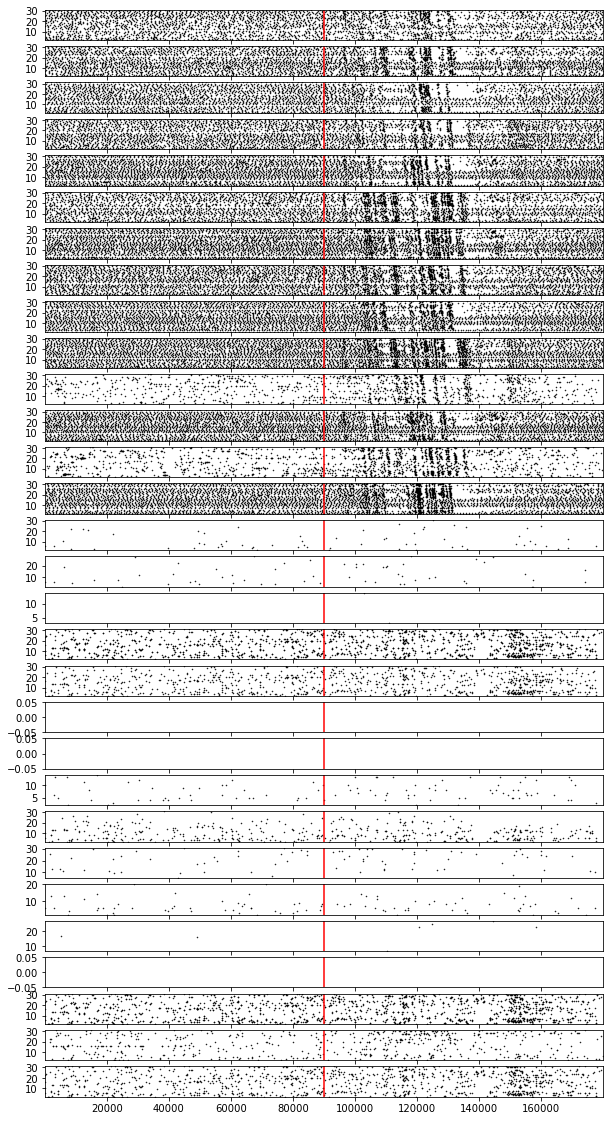

In [16]:
fig, ax_arr = plt.subplots(nrows=30, figsize=[10, 20], sharex=True)

for i_rast, clu_idx in enumerate(range(30)):    
    #one_raster_ms = coarse(rast_arr[clu_idx].T, samples_in_ms)
    #plt.imshow(one_raster_ms[::-1], aspect='auto', cmap='inferno')
    pu.plot_as_raster(rast_arr[clu_idx].T, t_0=-t_pre_samp, ax=ax_arr[i_rast])

## GPFA

In [17]:
def collect_bout(bout_dict, bout_idx, run_recordings, t_pre, t_post, spk_df, clu_list, mic_stream):
    s_f_ap = run_recordings['ap_0']._s_f_0
    s_f_nidq = run_recordings['nidq']._s_f_0
    
    ## add the length of the bout (in seconds) to the end of the segment
    t_post += int(bout_dict['len_ms'][bout_idx] * 0.001)
       
    start_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f']* t_pre)
    end_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_post)

    start_wav = bout_dict['start_sample_wav'][bout_idx] + int(all_syn_dict['wav']['s_f'] * t_pre)
    end_wav = bout_dict['start_sample_wav'][bout_idx] + int(all_syn_dict['wav']['s_f'] * t_post)


    # get the streams/spike array
    spk_arr = ks.get_window_spikes(spk_df, clu_list, int(start_ap), int(end_ap))
    mic_arr = mic_stream.flatten()[start_wav: end_wav]
    
    return spk_arr, mic_arr

In [19]:
s_f_wav, mic_stream = wu.read_wav_chan(exp_struct['files']['wav_mic'])

In [20]:
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['ra'])), 
                                'cluster_id'])

spk_arr_list = []
mic_arr_list = []
clu_id_arr_list = []

t_pre = -0.05
t_post = 0.05

## get the bouts arrays
for bout_idx, start in enumerate(bout_dict['start_ms']):
    spk_arr, mic_arr = collect_bout(bout_dict, bout_idx, run_recordings, t_pre, t_post, spk_df, clu_list, mic_stream)
    spk_arr_list.append(spk_arr.astype(np.short))
    mic_arr_list.append(mic_arr.astype(np.int16))
    clu_id_arr_list.append(np.array(clu_list).astype(np.int16))
    

## make into a pandas dataframe
bout_dict['spk_arr'] = spk_arr_list
bout_dict['mic_arr'] = mic_arr_list
bout_dict['clu_id_arr'] = clu_id_arr_list
bout_dict['t_pre_s'] = t_pre
bout_dict['t_post_s'] = t_post

keys_to_df = ['start_sample_nidq', 'start_sample_ap_0', 'len_ms', 'spk_arr', 'mic_arr', 'clu_id_arr',
             'stim_name']

bout_dict_df = {k: bout_dict[k] for k in keys_to_df}
bout_df = pd.DataFrame.from_dict(bout_dict_df)

bout_df.head()

,start_sample_nidq,start_sample_ap_0,len_ms,spk_arr,mic_arr,clu_id_arr,stim_name
0,2060216,2472348,1931.426291,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-665, -710, 216, -379, -98, -215, -449, 593, ...","[10, 18, 22, 23, 27, 28, 29, 30, 42, 56, 71, 7...",08-00-01-02_38377
1,2422985,2907812,1931.466291,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[321, -326, 318, -267, -866, -245, -157, -911,...","[10, 18, 22, 23, 27, 28, 29, 30, 42, 56, 71, 7...",08-00-01-02_38377-rev
2,2755601,3306892,2999.520829,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[609, 390, 293, 154, 637, 1041, 614, 837, 223,...","[10, 18, 22, 23, 27, 28, 29, 30, 42, 56, 71, 7...",z047_motiff_0
3,3153774,3784736,1931.386290,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[286, 502, 256, 272, 135, -194, 94, -130, -231...","[10, 18, 22, 23, 27, 28, 29, 30, 42, 56, 71, 7...",08-00-01-02_38377
4,3485789,4183072,1930.946284,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-154, 95, -183, 350, 473, 393, 450, 331, 21, ...","[10, 18, 22, 23, 27, 28, 29, 30, 42, 56, 71, 7...",08-00-01-02_38377-rev


In [49]:
bout_sel =(bout_df['stim_name'] == stim_name)

In [50]:
### compute the spectrograms
s_f_wav = trial_dict['s_f']

bout_df['sxx_all'] = bout_df['mic_arr'].apply(lambda x: sp.ms_spectrogram(x.flatten(), s_f_wav, 
                                                                         f_min=100, f_max=9000)
                                             )
bout_df['sxx'] = bout_df['sxx_all'].apply(lambda x: x[2])

In [89]:
def plot_bout(bout_series, ax, cmap='inferno'):
    sxx = bout_series['sxx']
    #print(sxx.shape)
    t = np.arange(sxx.shape[1])
    f = np.arange(sxx.shape[0])
    ax.pcolormesh(t, f, np.log(sxx), cmap=cmap)
    return ax, t


i_bout = 15

x = np.log(bout_df.iloc[i_bout]['sxx'])

pca = PCA(n_components=3, svd_solver='full')
pca.fit(x.T)

y = pca.transform(x.T)

fig, ax = plt.subplots(nrows=2, figsize=(8, 2*2), sharex=False)
ax[0], t = plot_bout(bout_df.iloc[i_bout], ax[0])
ax[1].plot(t, y)

KeyError: 'sxx'

In [63]:
bout_df[bout_sel]

,start_sample_nidq,start_sample_ap_0,len_ms,spk_arr,mic_arr,clu_id_arr,stim_name,sxx_all,sxx
0,2060216,2472348,1931.426291,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-622, -388, -570, -254, 87, 90, -180, -448, -...","[10, 18, 22, 23, 27, 28, 29, 30, 42, 56, 71, 7...",08-00-01-02_38377,"([146.48238105678672, 195.30984140904897, 244....","[[40726.71, 38703.887, 36045.586, 32569.055, 2..."
3,3153774,3784736,1931.386290,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1040, 182, 373, 556, -57, -28, -101, 683, 115...","[10, 18, 22, 23, 27, 28, 29, 30, 42, 56, 71, 7...",08-00-01-02_38377,"([146.48238105678672, 195.30984140904897, 244....","[[20063.875, 21893.71, 22015.188, 22471.475, 2..."
5,3817854,4581630,1931.426291,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[192, 200, 252, 121, -245, -29, -231, 149, -95...","[10, 18, 22, 23, 27, 28, 29, 30, 42, 56, 71, 7...",08-00-01-02_38377,"([146.48238105678672, 195.30984140904897, 244....","[[13026.637, 11535.943, 9564.605, 7493.0366, 6..."
9,5224224,6269402,1931.426291,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[173, 210, 69, 375, 261, 10, 317, 41, 330, 364...","[10, 18, 22, 23, 27, 28, 29, 30, 42, 56, 71, 7...",08-00-01-02_38377,"([146.48238105678672, 195.30984140904897, 244....","[[8034.4136, 9192.314, 9316.596, 8998.116, 877..."
11,5935560,7122876,1931.426291,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-580, -1100, -397, 116, -177, -12, -475, 3, 5...","[10, 18, 22, 23, 27, 28, 29, 30, 42, 56, 71, 7...",08-00-01-02_38377,"([146.48238105678672, 195.30984140904897, 244....","[[7425.2295, 6290.8, 5252.6675, 5019.102, 5138..."
14,6952182,8342966,1931.426291,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[614, 318, 593, 454, 913, 556, 426, 397, -38, ...","[10, 18, 22, 23, 27, 28, 29, 30, 42, 56, 71, 7...",08-00-01-02_38377,"([146.48238105678672, 195.30984140904897, 244....","[[18407.926, 19032.146, 17784.422, 14635.121, ..."
15,7316452,8780042,1931.386290,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-505, -379, -256, -1015, -640, -543, -234, -1...","[10, 18, 22, 23, 27, 28, 29, 30, 42, 56, 71, 7...",08-00-01-02_38377,"([146.48238105678672, 195.30984140904897, 244....","[[19251.469, 17265.023, 13428.508, 8767.245, 6..."
22,9766672,11720386,1931.426291,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-1020, -505, -833, -513, -480, -220, -657, -1...","[10, 18, 22, 23, 27, 28, 29, 30, 42, 56, 71, 7...",08-00-01-02_38377,"([146.48238105678672, 195.30984140904897, 244....","[[1.0, 1.0, 1.0, 3727.567, 4824.2026, 5222.759..."
23,10115790,12139327,1931.426291,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[264, -639, 20, -21, -456, -822, -556, -527, -...","[10, 18, 22, 23, 27, 28, 29, 30, 42, 56, 71, 7...",08-00-01-02_38377,"([146.48238105678672, 195.30984140904897, 244....","[[14524.8, 20038.771, 26956.525, 28714.691, 26..."
27,11568615,13882802,1931.426291,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[548, 531, 736, 606, 427, 417, -87, 474, -54, ...","[10, 18, 22, 23, 27, 28, 29, 30, 42, 56, 71, 7...",08-00-01-02_38377,"([146.48238105678672, 195.30984140904897, 244....","[[4314.2456, 3887.4248, 1.0, 1.0, 1.0, 1.0, 1...."


In [59]:
def spike_trains_from_bout(bout_s: pd.Series, s_f=30000):
    # get the bout spike array
    spk_arr = bout_s['spk_arr']
    
    # get the time of the spikes
    # make a neo SpikeTrain for each cluster
    t_stop = spk_arr.shape[1]/s_f
    spk_train_list = [neo.SpikeTrain(times=np.where(x==1)[0]/s_f, units='sec', t_stop=t_stop) for x in spk_arr]
    
    return spk_train_list

i_bout = 15
bout_spk_trains = spike_trains_from_bout(bout_df.iloc[i_bout])

# get thte spike trains for all bouts
all_bout_idx = list(bout_df[].index)

all_spk_trains = [spike_trains_from_bout(bout_df.iloc[i_bout]) for i_bout in all_bout_idx]

### get also the spectrograms
all_spectrograms_list = [bout_df.iloc[i_bout]['sxx'] for i_bout in all_bout_idx]

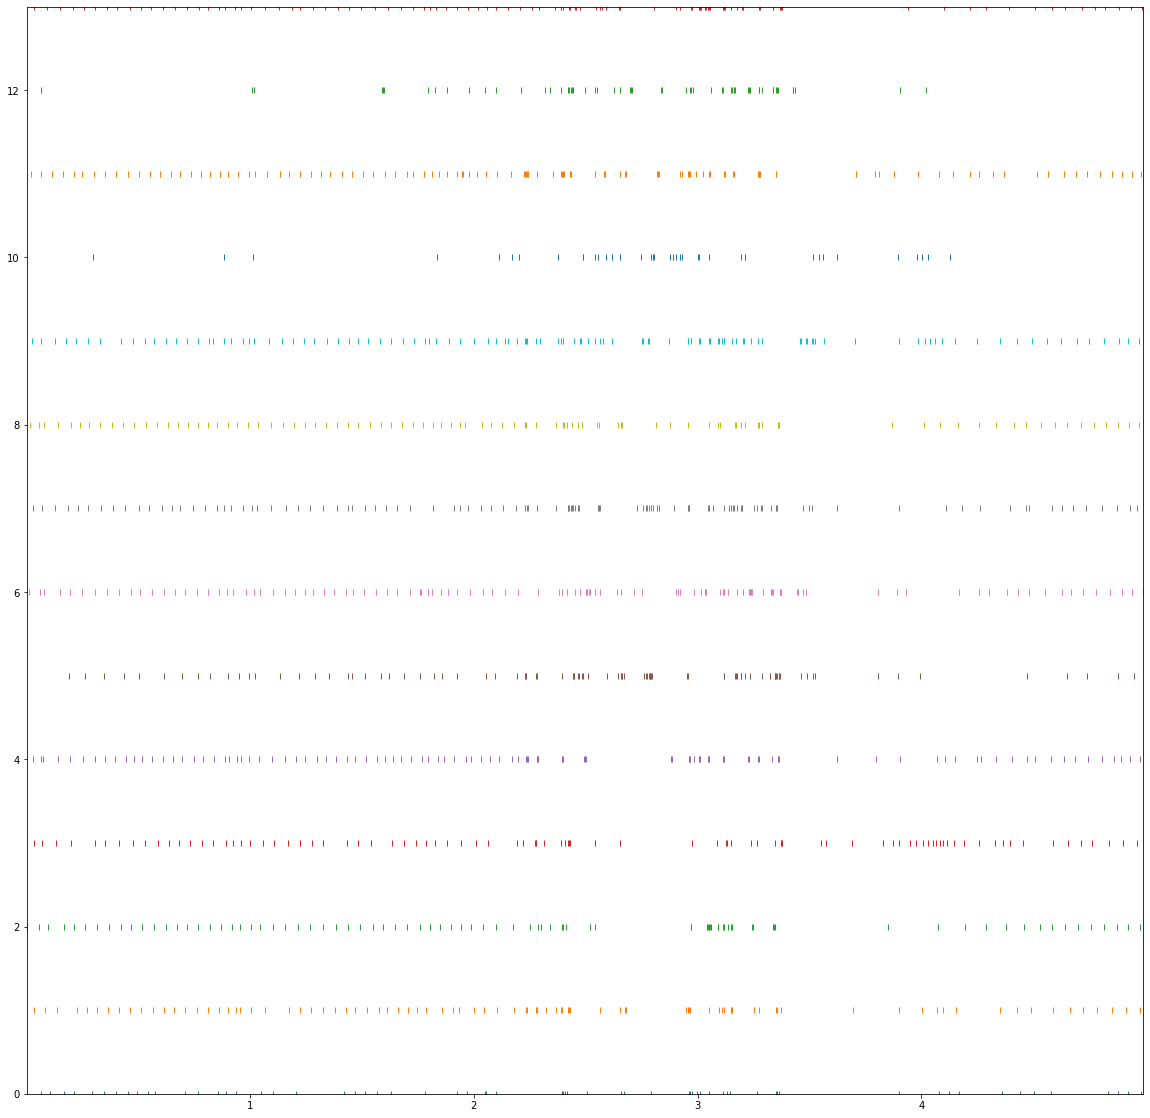

In [60]:
fig, ax = plt.subplots(figsize=(20, 20))

for i, spiketrain in enumerate(bout_spk_trains):
    ax.plot(spiketrain, np.ones_like(spiketrain) * i, ls='', marker='|')

In [61]:
# specify fitting parameters
bin_ms = 15
bin_size = bin_ms * pq.ms

latent_dimensionality = 6

gpfa_2dim = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)

In [62]:
gpfa_2dim.fit(all_spk_trains)
print(gpfa_2dim.params_estimated.keys())

/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 8 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 5 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:116

Initializing parameters using factor analysis...

Fitting GPFA model...
dict_keys(['covType', 'gamma', 'eps', 'd', 'C', 'R', 'notes'])


In [64]:
# get the trajectories for all the trials now
trial_trajectories = gpfa_2dim.transform(all_spk_trains)

/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 8 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 5 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:116

ValueError: all input arrays must have the same shape

In [ ]:
### dump them into the bout_df

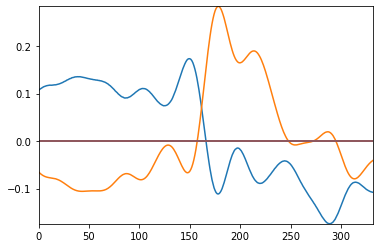

In [65]:
bout_df['gpfa'] = trial_trajectories
bout_df['gpfa'] = bout_df['gpfa'].apply(lambda x: x.T)
plt.plot(bout_df.iloc[0]['gpfa']);

In [ ]:
# arrange them all into a single array [trial, latent_dim, bin]
trial_trajectories_arr = np.stack(trial_trajectories, axis=0)
trial_trajectories_arr.shape

In [84]:
stim_names_arr

array(['08-00-01-02-116773', '08-00-01-02-116773-rev',
       '08-00-01-02_38377', '08-00-01-02_38377-rev', 'z047_motiff_0'],
      dtype=object)

In [67]:
### get all trajectories for a given stimulus
stim_name = stim_names_arr[0]

bout_sel = bout_df['stim_name'] == stim_name

In [73]:
stim_gpfa = bout_df.loc[bout_sel, 'gpfa'].values

shortest_gpfa = np.min([x.shape[0] for x in stim_gpfa])

gpfa_arr = np.stack([x[:shortest_gpfa] for x in stim_gpfa])

In [74]:
gpfa_arr.shape

(30, 333, 6)

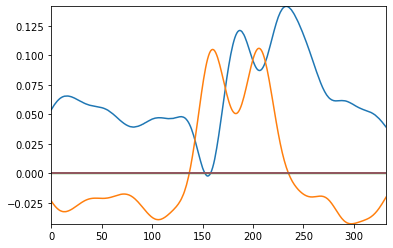

In [81]:
plt.plot(gpfa_arr.mean(axis=0))
#plt.plot(gpfa_arr[0])

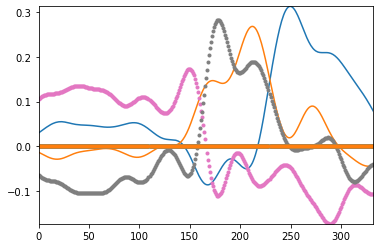

In [87]:
### get all trajectories for a given stimulus
stim_name = stim_names_arr[2]

bout_sel = bout_df['stim_name'] == stim_name

stim_gpfa = bout_df.loc[bout_sel, 'gpfa'].values

shortest_gpfa = np.min([x.shape[0] for x in stim_gpfa])

gpfa_arr = np.stack([x[:shortest_gpfa] for x in stim_gpfa])

plt.plot(gpfa_arr.mean(axis=0))
plt.plot(gpfa_arr[0], '.')

In [ ]:
### get all trajectories for a given stimulus
stim_name = stim_names_arr[1]

bout_sel = bout_df['stim_name'] == stim_name

stim_gpfa = bout_df.loc[bout_sel, 'gpfa'].values

shortest_gpfa = np.min([x.shape[0] for x in stim_gpfa])

gpfa_arr = np.stack([x[:shortest_gpfa] for x in stim_gpfa])

plt.plot(gpfa_arr.mean(axis=0))

### collect spikes into the bout_df

In [410]:
def collect_bout(bout_dict, bout_idx, run_recordings, t_pre, t_post, spk_df, clu_list, mic_stream):
    s_f_ap = run_recordings['ap_0']._s_f_0
    s_f_nidq = run_recordings['nidq']._s_f_0
    
    ## add the length of the bout (in seconds) to the end of the segment
    t_post += int(bout_dict['len_ms'][bout_idx] * 0.001)
       
    start_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f']* t_pre)
    end_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_post)

    start_wav = bout_dict['start_sample_wav'][bout_idx] + int(all_syn_dict['wav']['s_f'] * t_pre)
    end_wav = bout_dict['start_sample_wav'][bout_idx] + int(all_syn_dict['wav']['s_f'] * t_post)


    # get the streams/spike array
    spk_arr = get_window_spikes(spk_df, clu_list, int(start_ap), int(end_ap))
    mic_arr = mic_stream.flatten()[start_wav: end_wav]
    
    return spk_arr, mic_arr

In [411]:
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['ra'])), 
                                'cluster_id'])

spk_arr_list = []
mic_arr_list = []
clu_id_arr_list = []

t_pre = -2
t_post = 2

## get the bouts arrays
for bout_idx, start in enumerate(bout_dict['start_ms']):
    spk_arr, mic_arr = collect_bout(bout_dict, bout_idx, run_recordings, t_pre, t_post, spk_df, clu_list, mic_stream)
    spk_arr_list.append(spk_arr.astype(np.short))
    mic_arr_list.append(mic_arr.astype(np.int16))
    clu_id_arr_list.append(np.array(clu_list).astype(np.int16))
    

## make into a pandas dataframe
bout_dict['spk_arr'] = spk_arr_list
bout_dict['mic_arr'] = mic_arr_list
bout_dict['clu_id_arr'] = clu_id_arr_list
bout_dict['t_pre_s'] = t_pre
bout_dict['t_post_s'] = t_post

keys_to_df = ['start_sample_nidq', 'start_sample_ap_0', 'len_ms', 'spk_arr', 'mic_arr', 'clu_id_arr']

bout_dict_df = {k: bout_dict[k] for k in keys_to_df}
bout_df = pd.DataFrame.from_dict(bout_dict_df)

bout_df.head()

<ipython-input-346-d9e10a508dbb>:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]


,start_sample_nidq,start_sample_ap_0,len_ms,spk_arr,mic_arr,clu_id_arr
0,2060217,2472348,1931.426291,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-622, -388, -570, -254, 87, 90, -180, -448, -...","[10, 18, 22, 23, 27, 28, 29, 30, 42, 56, 71, 7..."
1,2422986,2907812,1931.466291,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[507, 437, 302, -63, -176, -137, 86, 169, -487...","[10, 18, 22, 23, 27, 28, 29, 30, 42, 56, 71, 7..."
2,2755602,3306892,2999.520829,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-269, 218, -164, -79, 722, 811, 844, 1129, 10...","[10, 18, 22, 23, 27, 28, 29, 30, 42, 56, 71, 7..."
3,3153775,3784736,1931.386290,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1040, 182, 373, 556, -57, -28, -101, 683, 115...","[10, 18, 22, 23, 27, 28, 29, 30, 42, 56, 71, 7..."
4,3485790,4183072,1930.946284,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[661, 1017, 698, 425, 693, 657, 993, 876, 343,...","[10, 18, 22, 23, 27, 28, 29, 30, 42, 56, 71, 7..."


### do the gpfa

In [412]:
bout_df.keys()

Index(['start_sample_nidq', 'start_sample_ap_0', 'len_ms', 'spk_arr',
       'mic_arr', 'clu_id_arr'],
      dtype='object')

In [440]:
one_len = bout_df['len_ms'].values[0]

In [443]:
bout_df['keep'] = np.nan
bout_df.loc[bout_df['len_ms'] == one_len, 'keep'] = True


In [445]:
bout_df.dropna(inplace=True)

In [449]:
bout_df.reset_index(inplace=True)

In [450]:
bout_df.head(1)

,index,start_sample_nidq,start_sample_ap_0,len_ms,spk_arr,mic_arr,clu_id_arr,sxx_all,sxx,fr_arr,keep
0,0,2060217,2472348,1931.426291,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-622, -388, -570, -254, 87, 90, -180, -448, -...","[10, 18, 22, 23, 27, 28, 29, 30, 42, 56, 71, 7...","([146.48238105678672, 195.30984140904897, 244....","[[40726.71, 38703.887, 36045.586, 32569.055, 2...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True


In [451]:
s_f_wav = bout_dict['s_f']
bout_df['sxx_all'] = bout_df['mic_arr'].apply(lambda x: sp.ms_spectrogram(x.flatten(), s_f_wav, 
                                                                         f_min=100, f_max=9000)
                                             )

bout_df['sxx'] = bout_df['sxx_all'].apply(lambda x: x[2])

In [452]:
s_f_ap_0 = bout_dict['s_f_ap_0']

bin_size_ms = 1
bin_size_sample = int(bin_size_ms * 0.001 *  s_f_ap_0)

bout_df['fr_arr'] =  bout_df['spk_arr'].apply(lambda x: pu.coarse(x, bin_size_sample))

In [453]:
from sklearn.decomposition import PCA

In [454]:
def plot_bout(bout_series, ax, cmap='inferno'):
    sxx = bout_series['sxx']
    #print(sxx.shape)
    t = np.arange(sxx.shape[1])
    f = np.arange(sxx.shape[0])
    ax.pcolormesh(t, f, np.log(sxx), cmap=cmap)
    return ax, t

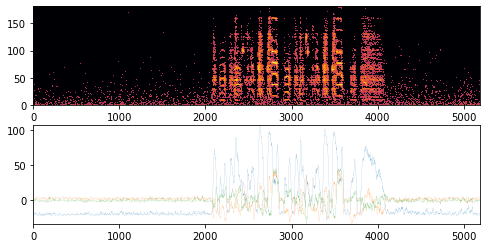

In [455]:
i_bout = 1

x = np.log(bout_df.iloc[i_bout]['sxx'])

pca = PCA(n_components=3, svd_solver='full')
pca.fit(x.T)

y = pca.transform(x.T)

fig, ax = plt.subplots(nrows=2, figsize=(8, 2*2), sharex=False)
ax[0], t = plot_bout(bout_df.iloc[i_bout], ax[0])
ax[1].plot(t, y)

In [456]:
import neo
from scipy.ndimage import gaussian_filter1d

In [457]:
def spike_trains_from_bout(bout_s: pd.Series, s_f=30000):
    # get the bout spike array
    spk_arr = bout_s['spk_arr']
    
    # get the time of the spikes
    # make a neo SpikeTrain for each cluster
    t_stop = spk_arr.shape[1]/s_f
    spk_train_list = [neo.SpikeTrain(times=np.where(x==1)[0]/s_f, units='sec', t_stop=t_stop) for x in spk_arr]
    
    return spk_train_list

i_bout = 5
bout_spk_trains = spike_trains_from_bout(bout_df.iloc[i_bout])

# get thte spike trains for all bouts
all_bout_idx = list(bout_df.index)
all_spk_trains = [spike_trains_from_bout(bout_df.iloc[i_bout]) for i_bout in all_bout_idx]

### get also the spectrograms
all_spectrograms_list = [bout_df.iloc[i_bout]['sxx'] for i_bout in all_bout_idx]

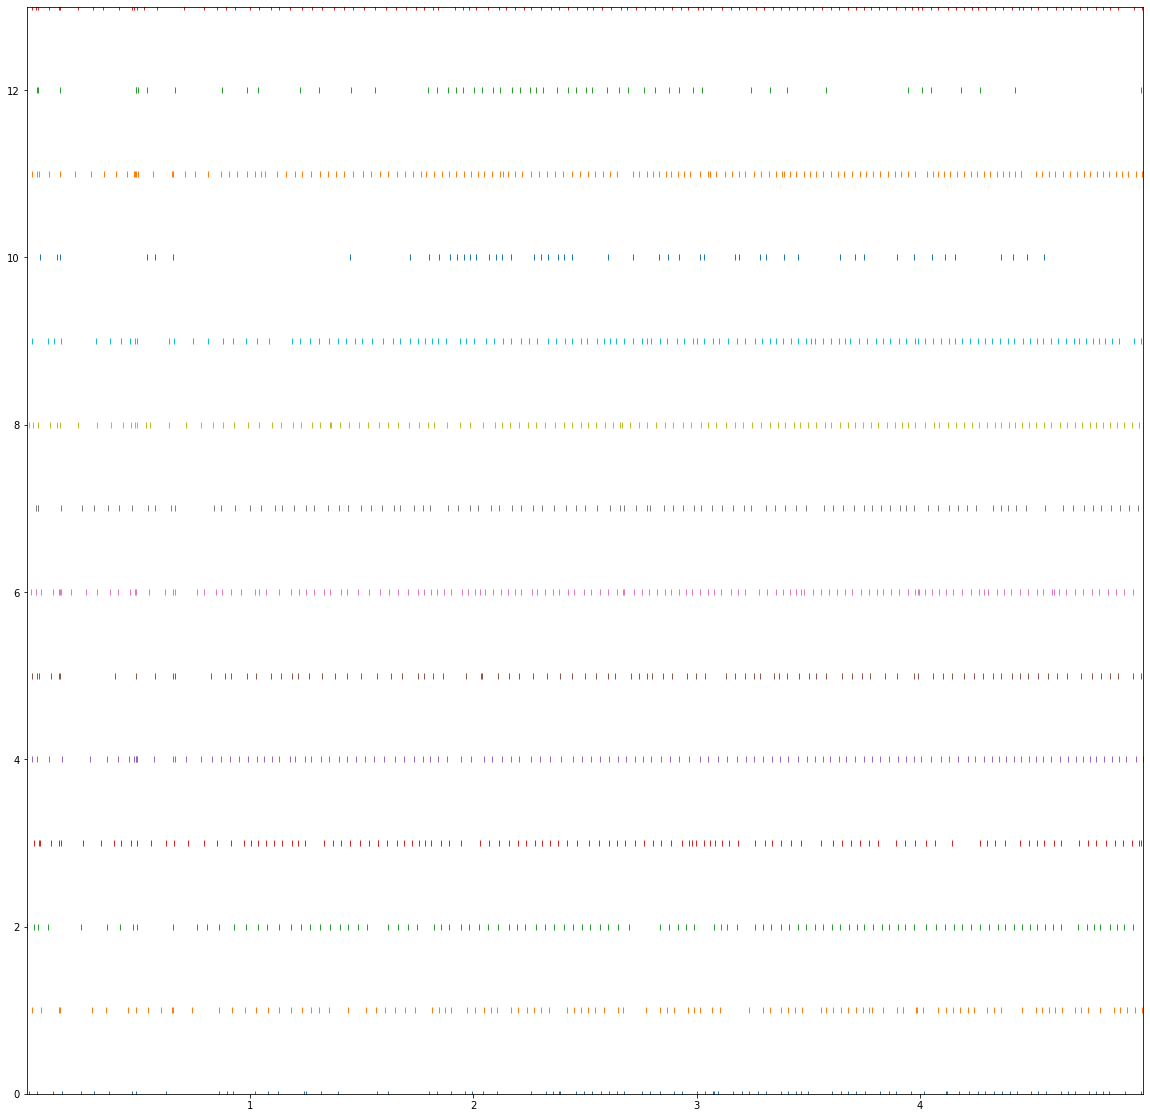

In [458]:
fig, ax = plt.subplots(figsize=(20, 20))

for i, spiketrain in enumerate(bout_spk_trains):
    ax.plot(spiketrain, np.ones_like(spiketrain) * i, ls='', marker='|')

In [459]:
import quantities as pq
from elephant.gpfa import GPFA

# specify fitting parameters
bin_ms = 15
bin_size = bin_ms * pq.ms

latent_dimensionality = 6

gpfa_2dim = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)

In [460]:
gpfa_2dim.fit(all_spk_trains)
print(gpfa_2dim.params_estimated.keys())

/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


Initializing parameters using factor analysis...

Fitting GPFA model...
dict_keys(['covType', 'gamma', 'eps', 'd', 'C', 'R', 'notes'])


In [461]:
len(all_spk_trains[0])

14

In [462]:
# get the trajectories for all the trials now
trial_trajectories = gpfa_2dim.transform(all_spk_trains)
# arrange them all into a single array [trial, latent_dim, bin]
trial_trajectories_arr = np.stack(trial_trajectories, axis=0)
trial_trajectories_arr.shape

/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 3 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "
/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 1 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


(27, 6, 333)

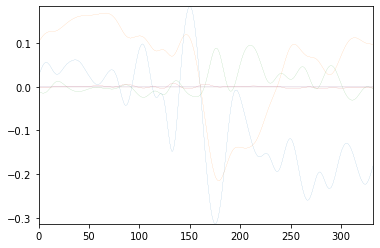

In [463]:
bout_df['gpfa'] = trial_trajectories
bout_df['gpfa'] = bout_df['gpfa'].apply(lambda x: x.T)
plt.plot(bout_df.iloc[0]['gpfa']);

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7efa113aeac0>)

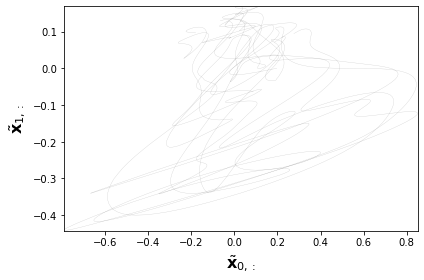

In [464]:
import viziphant as vp
vp.gpfa.plot_trajectories(trial_trajectories, gpfa_2dim, 
                                n_trials_to_plot=5, 
                                plot_group_averages=True)

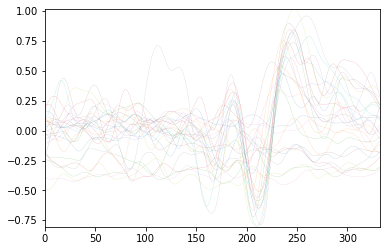

In [469]:
### time warp each to the longest and interpolate
# get the corresponding length and resample interpolate it
mot_start_bin = int(start_in_bout / bin_ms)

traj_list = []
t_list = []

for i_bout, one_trial_traj in enumerate(trial_trajectories):
    bout_s = bout_df.iloc[i_bout]
    #one_end_bin = int(bout_s['end_in_bout'] / bin_ms)
    # get the time scale
    # get as many samples of the trajetory starting in start_in_bout
    one_traj = one_trial_traj[:, : ]
    one_t = np.arange(one_traj.shape[1])
    plt.plot(one_t, one_traj[0])
    traj_list.append(one_traj)
    t_list.append(one_t)

In [470]:
# now it's easy to get the trajectories for the motifs
#mot_trajectories = trial_trajectories[:, :, mot_start_bin: mot_end_bin]
mot_trajectories = all_traj_arr
mot_trajectories.shape

# and the average by 'kind' of motif
avg_traj = [np.median(mot_trajectories[bout_dict['mot_kind']==x], axis=0) for x in np.unique(bout_dict['mot_kind'])]
avg_traj_arr = np.stack(avg_traj, axis=0)

NameError: name 'all_traj_arr' is not defined

NameError: name 'mot_trajectories' is not defined

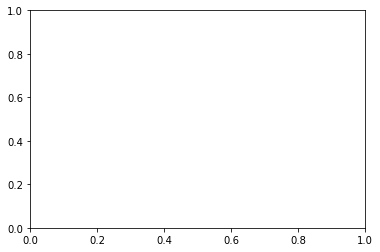

In [472]:
fig = plt.figure()
ax = fig.add_subplot(111)

for single_trial_trajectory in mot_trajectories[:]:
    ax.plot(single_trial_trajectory[0], single_trial_trajectory[2], '-', lw=0.75)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(avg_traj_arr[:, 0].T, '--')